# Scan data processing

The following sections take the folders full of scan data produced by Airtaskers and concatinate them into a cleaned, single csv. 

The steps are to:

* import each folder full of CSVs, concatinate them and deduplicate them. (this was important as they were payed by the scan so I needed to know what to pay them. It was deduped at this stage because I'm generally sloppy in life and I didn't want to have copied across multiple files that were the same but with different file names.)
* Add the badge ID to each person
* Concatinate into a single data set
* save it a CSV

Once that's done there are some steps to visualise the data.


In [1]:
import os
import pandas as pd
import datetime
import dateutil.parser
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imread

import helpers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

In [3]:
badgeMapping = {
    "blocker":    {"badgeName": "Aiden Ray",           "badgeID":   0},
    "Tiara":      {"badgeName": "probably valentine",  "badgeID":   0},#check
    "daniel":     {"badgeName": "Fred Holt",           "badgeID":   0},
    "Julia":      {"badgeName": "toCheckA",            "badgeID":   0},#check
    "Zoheb":      {"badgeName": "NT",                  "badgeID":   0},
    "betsabe":    {"badgeName": "toCheckB",            "badgeID":   0},#check
    "simon":      {"badgeName": "toCheckC",            "badgeID":   0},#check
    "Hugh":       {"badgeName": "Louise Villmunsen",   "badgeID":   0},
    "aron":       {"badgeName": "James Grose",         "badgeID":   0},
    "Yudie":      {"badgeName": "Louise Villmunsen",   "badgeID":   0},
    "rick":       {"badgeName": "Fred Holt",           "badgeID":   0},
    "arjun":      {"badgeName": "Louise Villmunsen",   "badgeID":   0},
    "alicia":     {"badgeName": "valentine",           "badgeID":   0},
    "taha":       {"badgeName": "Aiden Ray",           "badgeID":   0},
    "michael":    {"badgeName": "NT",                  "badgeID":   0},
    "julia2":     {"badgeName": "minor375",            "badgeID": 375},
    "aliasgher":  {"badgeName": "connor",              "badgeID":   0},
    "mufaddal":   {"badgeName": "kirsten karst",       "badgeID":   0},
    "yudi2":      {"badgeName": "NT",                  "badgeID":   0}
}

In [4]:
def getiOS_df(path):
    def mergeTimeDate(x):
        return dateutil.parser.parse(x[u' Date'] + " " + x[u' Time'])

    df = pd.DataFrame.from_dict( pd.read_csv(path,
                                             header=0) 
                               )
    df["timeStamp"] = df.apply(lambda x: mergeTimeDate(x), axis=1 )
    df = df.drop([u' Date',u' Time', u'Name'], 1)
    df.columns = ["stickerID","timeStamp"]
    return df 

def getAndroid_df(path):
    def convertTimeStamp(x):
        return dateutil.parser.parse(x["timeStamp"])
    df = pd.read_csv( path, 
                      header=None,
                      names=["stickerID","detectionType","xstickerID","timeStamp","xID"])
    df["tempTimeStamp"] = df.apply(lambda x: convertTimeStamp(x), axis=1 )
    df = df.drop(["xstickerID","detectionType","xID","timeStamp"], 1)
    df.columns = ["stickerID","timeStamp"]
    return pd.DataFrame.from_dict(df)

In [5]:
dirs = os.listdir(u'scan data')

allData = []
for d in dirs:
    path = u'scan data/'+d
    csvs = os.listdir(path)
    thisPersonsData = []
    for csv in csvs:
        tempdf = pd.DataFrame.from_dict( pd.read_csv(path+"/"+csv ,header=None))
        if tempdf.shape[1] > 4: #more than 4 means iPhone
            df = getAndroid_df(path+"/"+csv)
        else:
            df = getiOS_df(path+"/"+csv)
        df["person"] = d
        df["badge"]  = badgeMapping[d]["badgeName"]
        df["minor"]  = badgeMapping[d]["badgeID"]
        df = df[df.stickerID<400]
        thisPersonsData.append( df )
        
    allthisPersonsData = pd.concat(thisPersonsData).drop_duplicates()
    if d == "Yudie":
        allthisPersonsData = allthisPersonsData[allthisPersonsData.timeStamp > datetime.datetime(2016, 11, 25, 16, 0)]
    print d, allthisPersonsData.shape
        
    allData.append({"data": allthisPersonsData, "name": d})

yudi2 (2486, 5)
Tiara (220, 5)
daniel (363, 5)
Yudie (1101, 5)
Julia (1516, 5)
julia2 (3312, 5)
alicia (2321, 5)
Zoheb (603, 5)
rick (414, 5)
betsabe (456, 5)
blocker (572, 5)
aliasgher (3757, 5)
michael (2760, 5)
simon (162, 5)
taha (3242, 5)
Hugh (488, 5)
aron (562, 5)
mufaddal (2726, 5)
arjun (2104, 5)


In [6]:
allUniqueDetections = pd.concat([x["data"] for x in allData])
print allUniqueDetections.shape #just checking that the numbers meet up different ways
allUniqueDetections.stickerID = pd.to_numeric(allUniqueDetections.stickerID) 
allUniqueDetections.reset_index(drop=True, inplace=True)
allUniqueDetections.head(5)

(29165, 5)


,stickerID,timeStamp,person,badge,minor
0,68,2016-11-28 17:36:39,yudi2,NT,0
1,67,2016-11-28 17:36:30,yudi2,NT,0
2,77,2016-11-28 17:36:24,yudi2,NT,0
3,81,2016-11-28 17:36:20,yudi2,NT,0
4,77,2016-11-28 17:36:14,yudi2,NT,0


In [7]:
allUniqueDetections.to_csv(path_or_buf="allScanDetections.csv")

By now, all the scan data is in the csv, the rest is just visualisation of those data to give you an idea of what you're getting into.

---

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc853cb89d0>]], dtype=object)

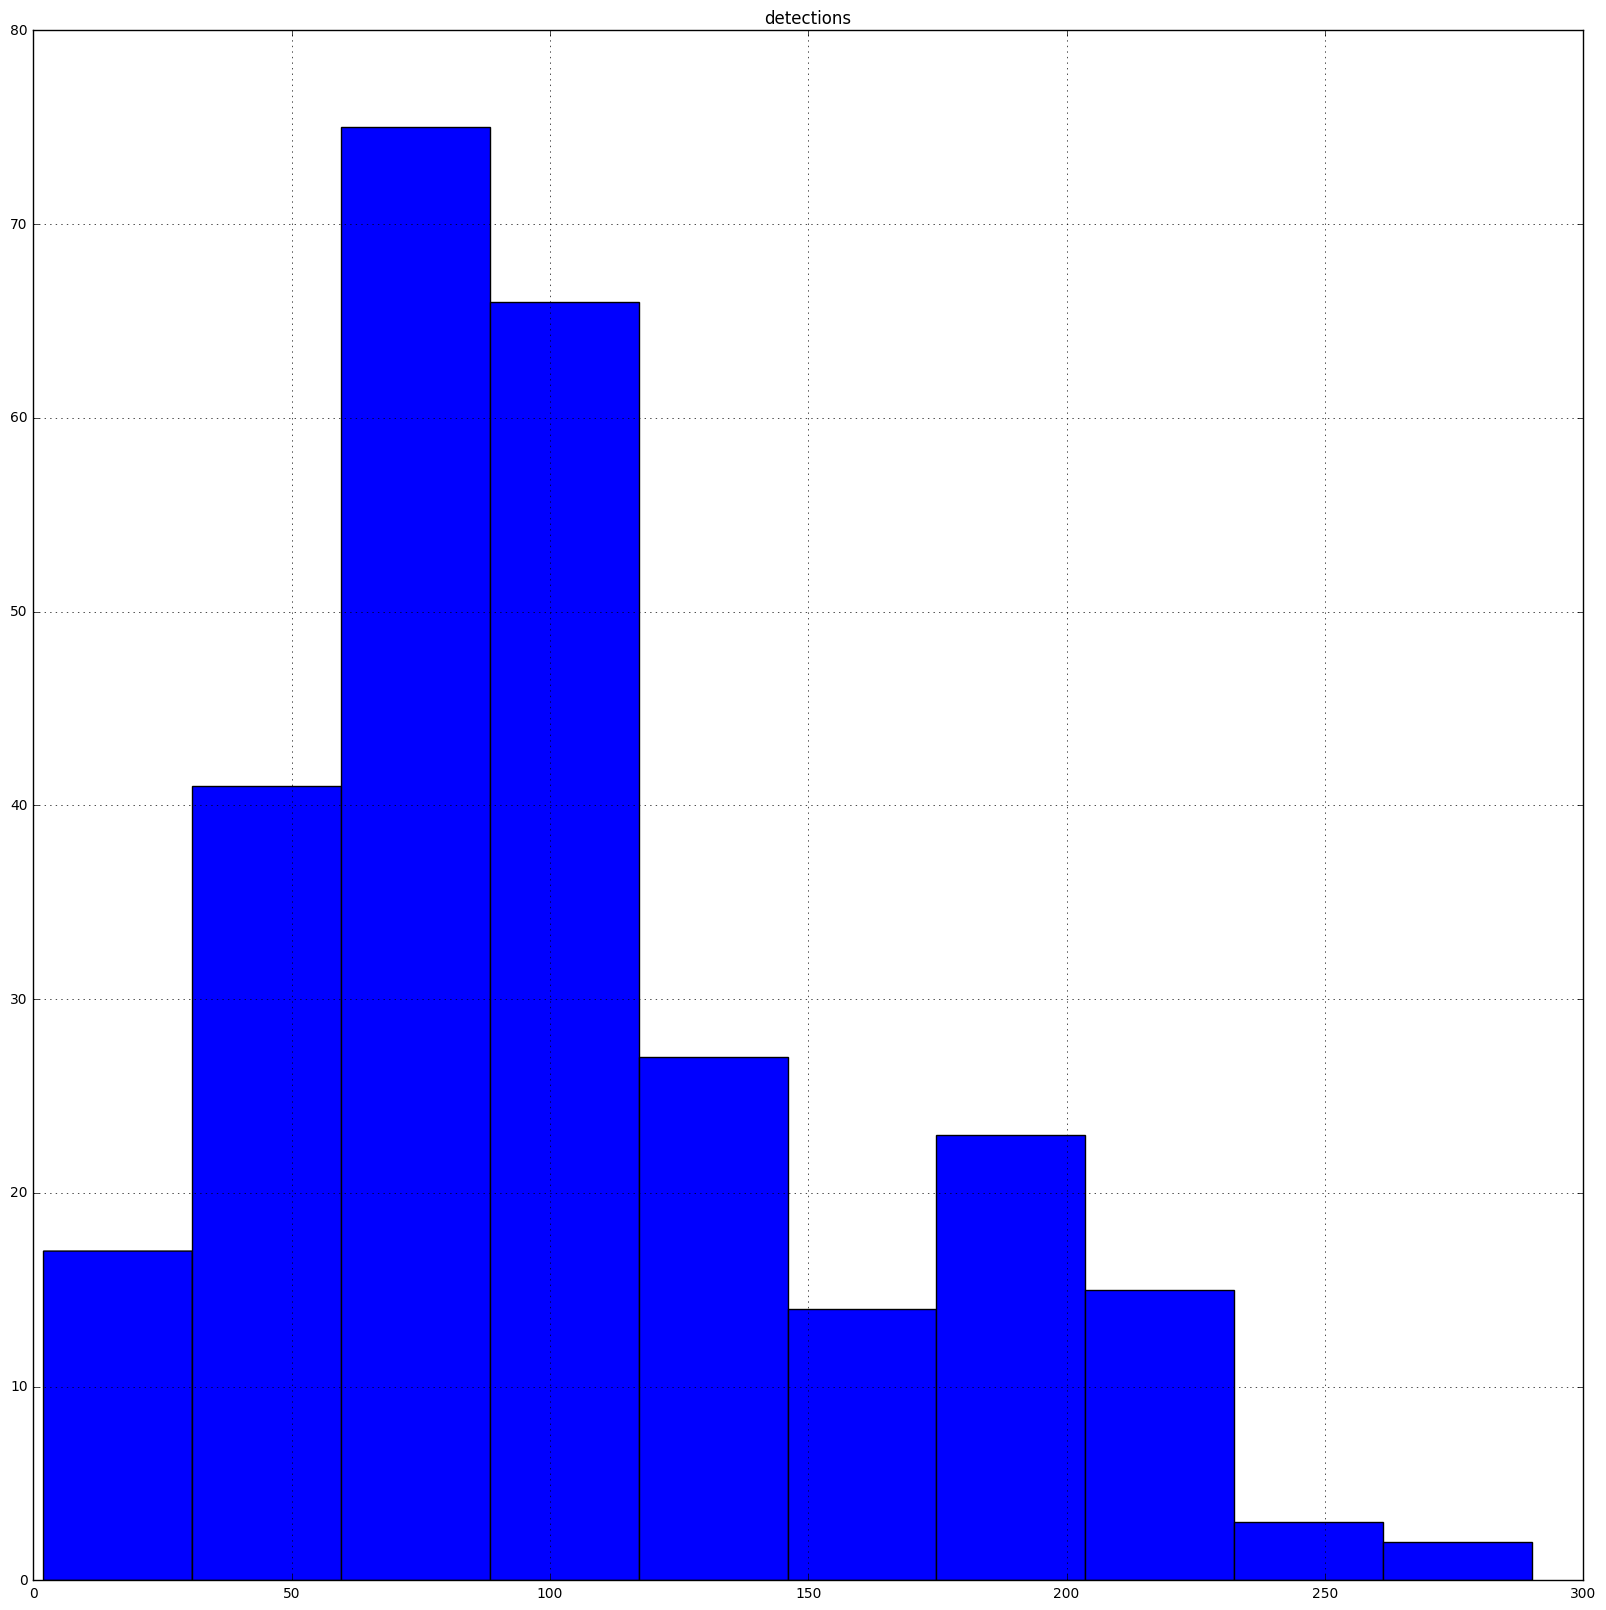

In [8]:
uniq = allUniqueDetections.stickerID.unique()
bins = {}
for u in uniq:
    bins[u] = []
    
scans = list(allUniqueDetections.stickerID)
for s in scans:
    bins[s].append(s)

for k in bins.keys():
    bins[k] = len(bins[k])
    
binDF = pd.DataFrame.from_dict(bins,orient='index')
binDF.columns = ["detections"]
binDF.hist()

In [9]:
stickerLocations = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/1sijQZR2iFLo2FS_3r5gbsuAkaglRz557LWjdLxnPkpE/pub?gid=0&single=true&output=csv")
stickerLocations = stickerLocations.drop(["z","raw"], 1) # this is just because we aren't on multiple floors
stickerLocations.head(3)

,stickerID,x,y
0,1,63852.09440,-13561.617780
1,2,62985.85359,-11830.460440
2,3,62985.85359,-9830.460444


In [10]:
baseStationData = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/167pxh_NRq5e9sQV9Zb8Z-Q-kdN7Zy9FCzCp47eVXTuE/pub?gid=1446311565&single=true&output=csv")
baseStationData = baseStationData.ix[:,0:5] #only keep the columns we care about
baseStationData = baseStationData.drop(["location"], 1)
baseStationData = baseStationData[baseStationData.agentId > 0] #not really sure how this works, maybe failure is falsy?
baseStationData.head(3)
baseStationData.agentName.unique()

array(['Ace', 'Alfa', 'Beer', 'Bravo', 'Charlie', 'Coco', 'Dee', 'Echo',
       'Edward', 'Foxtrot', 'Hotel', 'George', 'Golf', 'Harry', 'Freddie',
       'India', 'Ink', 'Johnnie', 'Juliett', 'Kilo', 'King', 'Lima',
       'London', 'Mike', 'Monkey', 'November', 'Nuts', 'Orange', 'Oscar',
       'Papa', 'Pip', 'Quebec', 'Queen', 'Robert', 'Romeo', 'Sierra',
       'Sugar', 'Tango', 'Tick', 'Uncle', 'Uniform', 'Vic', 'Victor',
       'Whisky', 'William'], dtype=object)

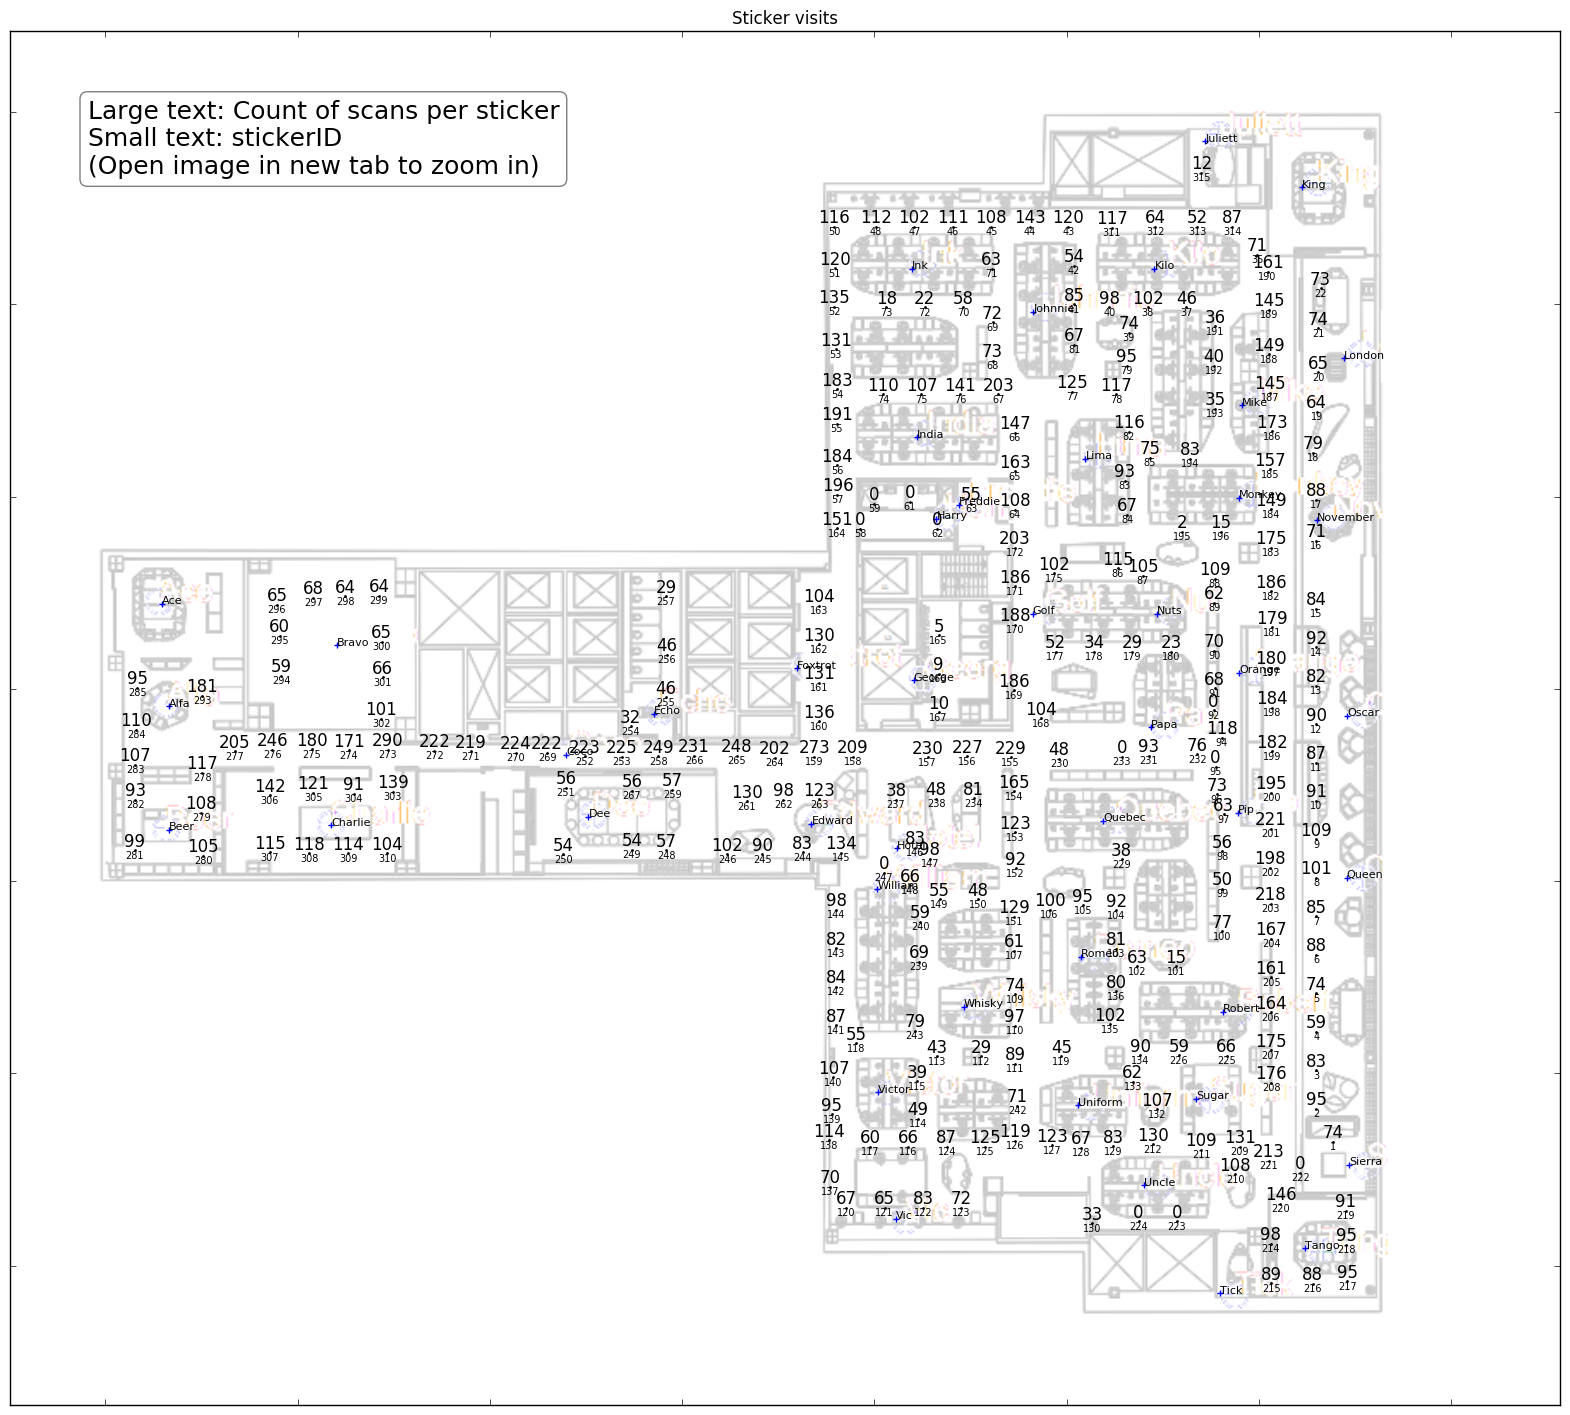

In [19]:
fig, ax = plt.subplots()

plt.title("Sticker visits")

#the sticker labels
for row in stickerLocations.iterrows():
    row = row[1] #BS indexing
    
    rowStickerID = int(row.stickerID)
    detectionCount = "duff"
    detectionCount = allUniqueDetections[allUniqueDetections.stickerID == rowStickerID].shape[0]
#     label = "{0}:\n{1}".format(rowStickerID, detectionCount)
    ax.text(row.x, row.y, rowStickerID,   fontsize= 7,  ha='center', va='top')
    ax.text(row.x, row.y, detectionCount, fontsize=12,  ha='center', va='bottom')

#sticker dots
ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y")


#put the image on the graph as an underlay
img = imread("map.png")
ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
#                                [left,  right, bottom, top  ]

#put the baseStations on the map 
for index, row in baseStationData.iterrows():
    ax.text(row.x, row.y, row.agentName, fontsize=8)
ax.scatter(baseStationData.x,baseStationData.y, marker='+')

#Hide the axis numbers because they don't tell us much
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())


fig.savefig("counts.pdf", bbox_inches='tight')

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, 
        "Large text: Count of scans per sticker\nSmall text: stickerID\n(Open image in new tab to zoom in)", 
        transform=ax.transAxes, 
        fontsize=18,
        verticalalignment='top', 
        bbox=props
       )

plt.show() #don't show, we need to save

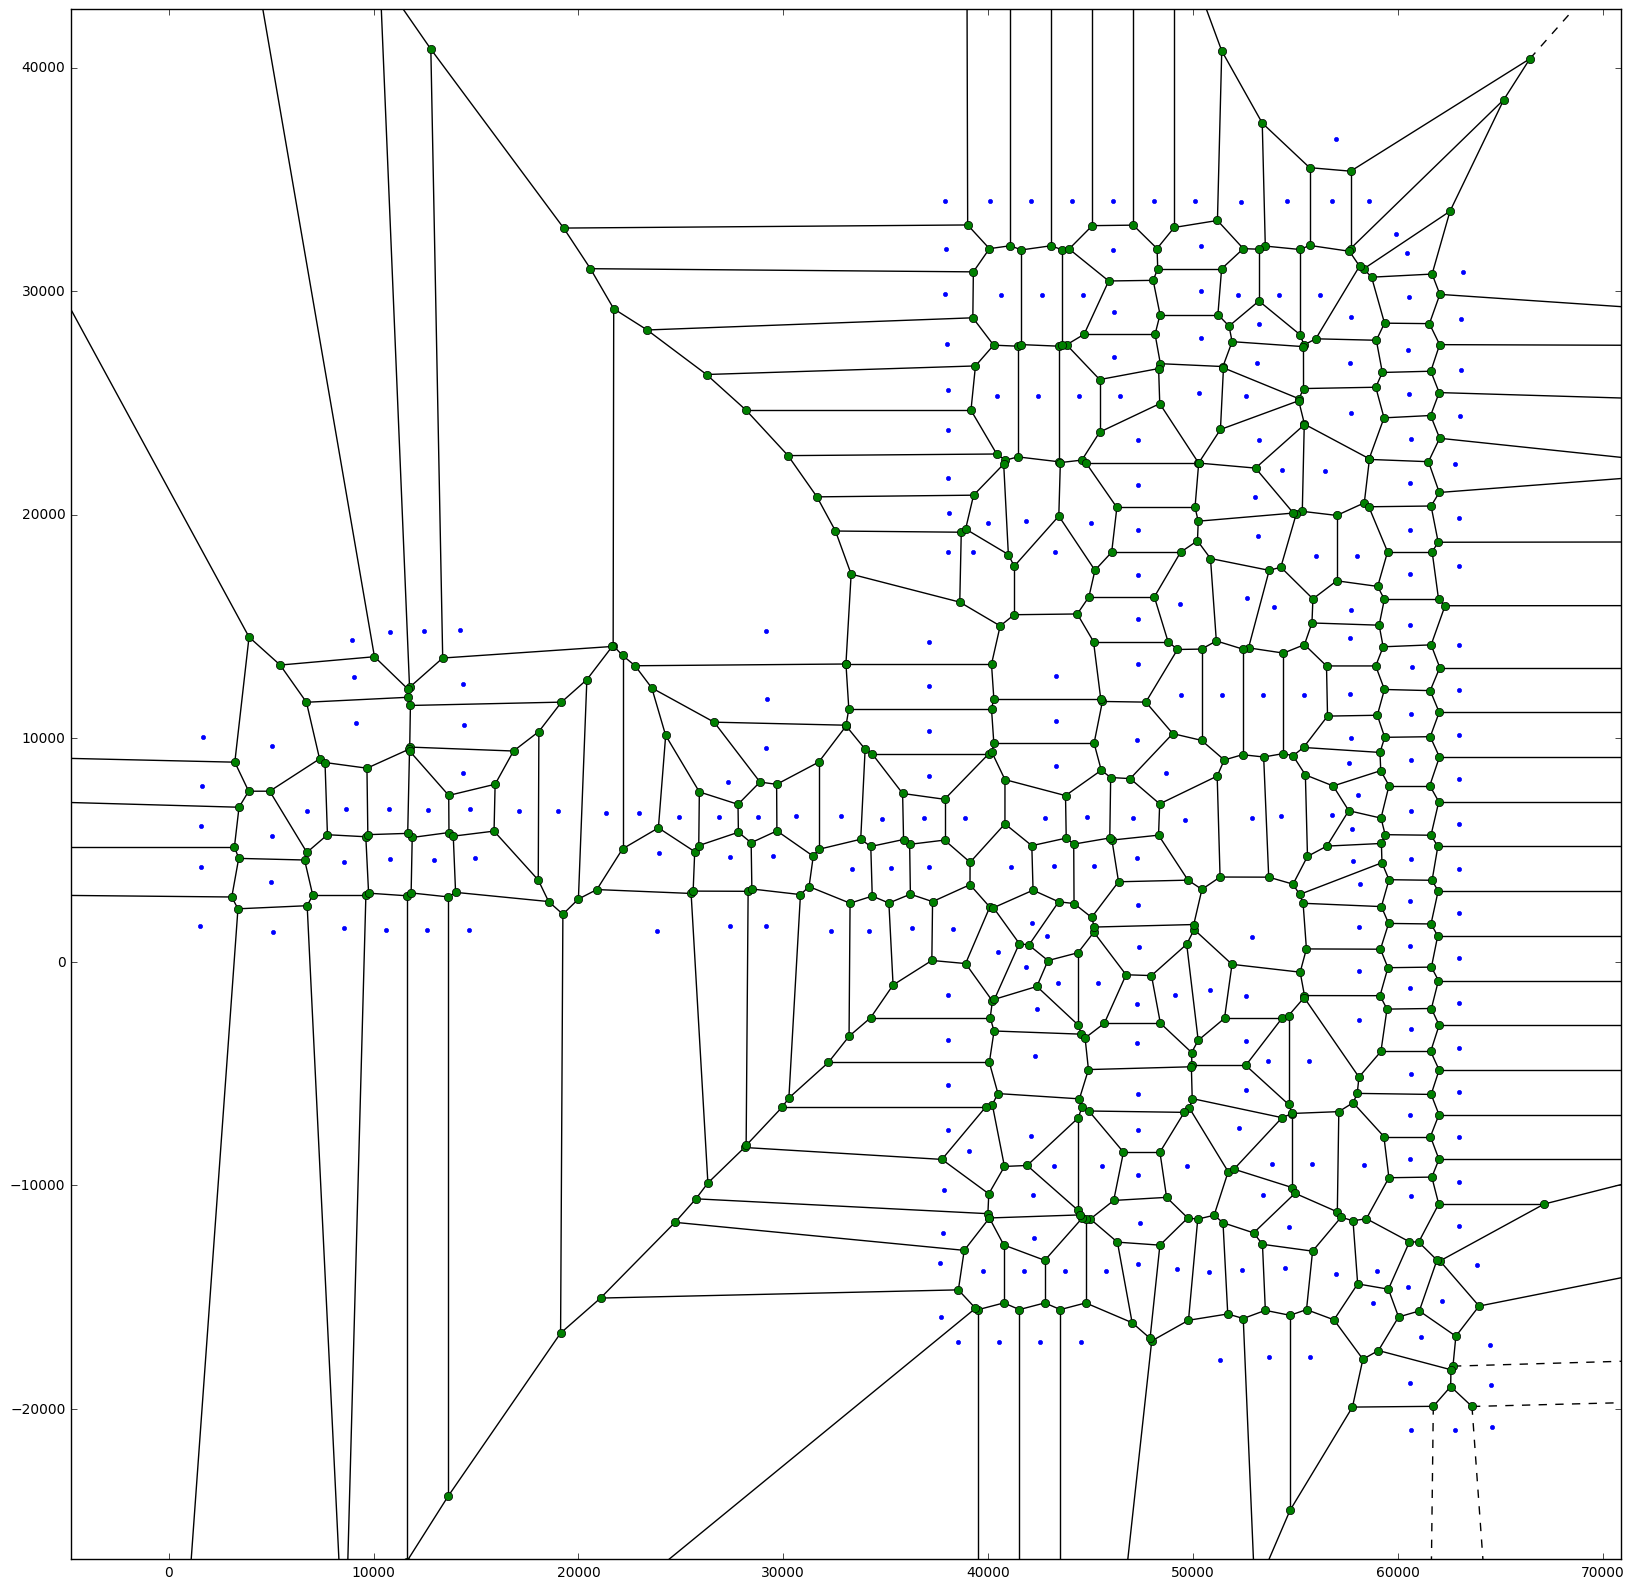

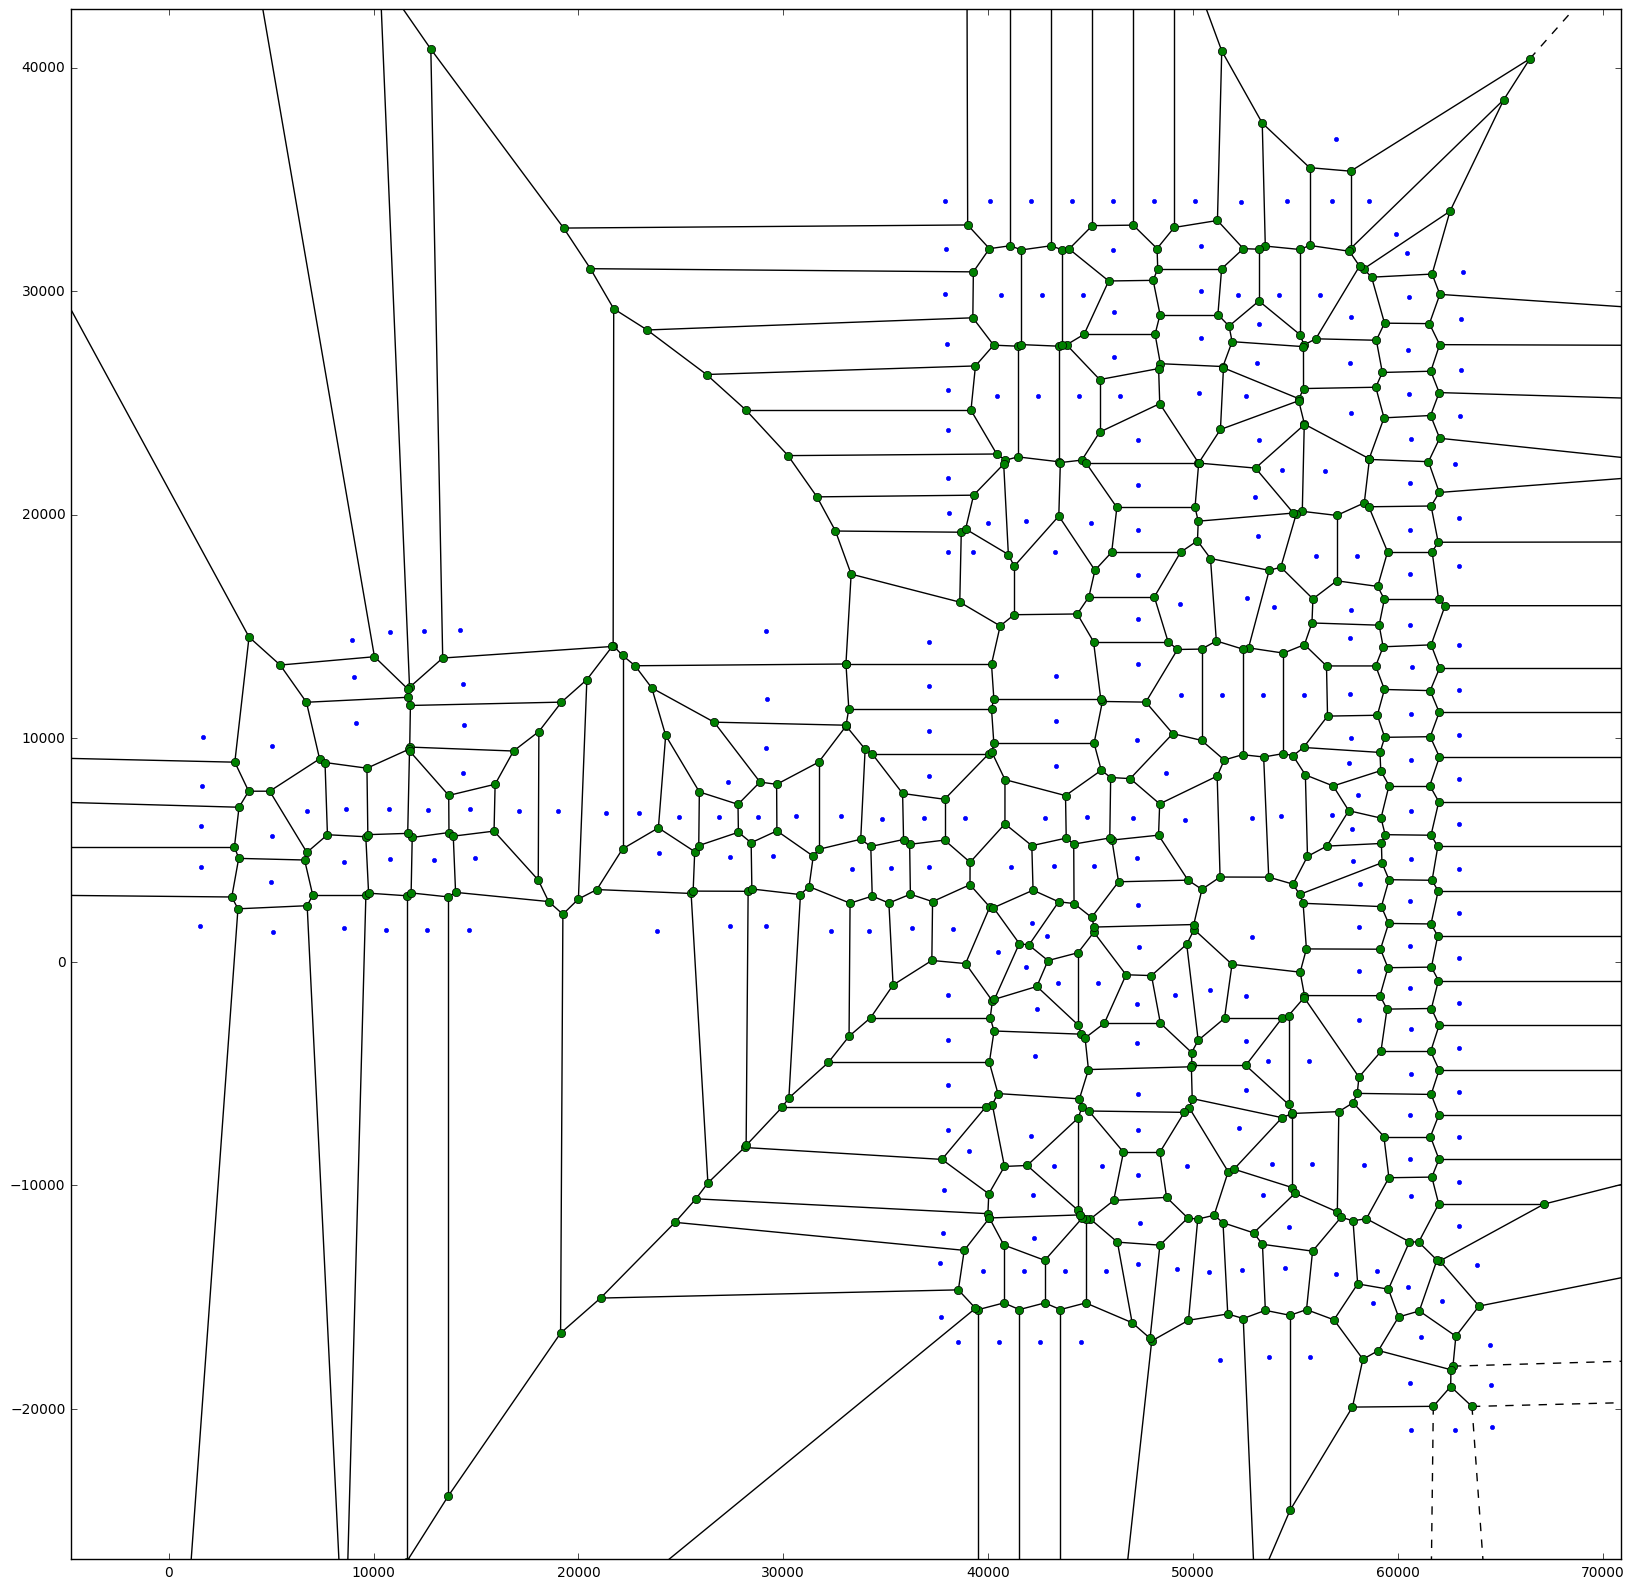

In [13]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi([[x[0],x[1]] for x in zip(stickerLocations.x,stickerLocations.y)])
voronoi_plot_2d(vor)
#not sure why it plots twice. I was trying to indicate the zone that each sticker covers (notionally)